## Assignment : 14 Part 2


<pre>
1. Preprocess all the Data we have in DonorsChoose <a href='https://drive.google.com/drive/folders/1MIwK7BQMev8f5CbDDVNLPaFGB32pFN60'>Dataset</a> use train.csv
2. Combine 4 essay's into one column named - 'preprocessed_essays'. 
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a href='https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric 
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
8. Use Categorical Cross Entropy as Loss to minimize.
</pre>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from numpy import zeros
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import LSTM,Bidirectional
from keras.layers.core import Dense, Dropout
from keras.models import Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

import keras
from tensorboardcolab import *
from keras.regularizers import l2
from keras.layers import LeakyReLU


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('/content/drive/My Drive/Applied ML assignments/preprocessed_data.csv')

In [4]:
df.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

In [5]:
df.shape

(109248, 9)

In [6]:
resource_data = pd.read_csv('/content/drive/My Drive/LSTM Assignment/resources.csv')
resource_data.columns
project_data = pd.read_csv('/content/drive/My Drive/LSTM Assignment/train_data.csv')
project_data.columns
#resource_data['quantity'].head

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [7]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [0]:
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [9]:
project_data['quantity'].shape

(109248,)

In [0]:
df['quantity'] = project_data['quantity']
#df1['columename']= df2['existing_colume_name']

In [0]:
df.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price',
       'quantity'],
      dtype='object')

In [0]:
df = df.reset_index()

In [0]:
y=df['project_is_approved']
df.drop(['project_is_approved'],axis=1, inplace=True)
x=df

In [12]:
#Splitting into train and test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
#Splitting train data into train and cv(60:20)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.2)
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)

(87398, 9) (87398,)
(21850, 9) (21850,)
(69918, 9) (69918,)
(17480, 9) (17480,)


Categorical features:
'school_state', 'teacher_prefix', 'project_grade_category','clean_categories', 'clean_subcategories'

In [0]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
from sklearn.preprocessing import LabelEncoder
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [14]:
#teacher_prefix
vectorizer = LabelEncoderExt()
vectorizer.fit(X_tr['teacher_prefix'].values)
teacherprefix_ohe_train = vectorizer.transform(X_tr['teacher_prefix'].values)
teacherprefix_ohe_cv = vectorizer.transform(X_cv['teacher_prefix'].values)
teacherprefix_ohe_test = vectorizer.transform(X_test['teacher_prefix'].values)
print(teacherprefix_ohe_cv.shape)
print(teacherprefix_ohe_train.shape)
print(teacherprefix_ohe_test.shape)

(17480,)
(69918,)
(21850,)


In [0]:
#Converting categorical features to One hot encoded features
#clean_categories
vectorizer = LabelEncoderExt()
vectorizer.fit(X_tr['clean_categories'].values)
categories_one_hot_train = vectorizer.transform(X_tr['clean_categories'].values)
categories_one_hot_cv = vectorizer.transform(X_cv['clean_categories'].values)
categories_one_hot_test = vectorizer.transform(X_test['clean_categories'].values)

#clean_subcategories
vectorizer = LabelEncoderExt()
vectorizer.fit(X_tr['clean_subcategories'].values)
subcategories_one_hot_train = vectorizer.transform(X_tr['clean_subcategories'].values)
subcategories_one_hot_cv = vectorizer.transform(X_cv['clean_subcategories'].values)
subcategories_one_hot_test = vectorizer.transform(X_test['clean_subcategories'].values)

#school_state
vectorizer = LabelEncoderExt()
vectorizer.fit(X_tr['school_state'].values)
schoolstate_one_hot_train = vectorizer.transform(X_tr['school_state'].values)
schoolstate_one_hot_cv = vectorizer.transform(X_cv['school_state'].values)
schoolstate_one_hot_test = vectorizer.transform(X_test['school_state'].values)


#project_grade_category
vectorizer = LabelEncoderExt()
vectorizer.fit(X_tr['project_grade_category'].values)
project_grade_category_one_hot_train = vectorizer.transform(X_tr['project_grade_category'].values)
project_grade_category_one_hot_cv = vectorizer.transform(X_cv['project_grade_category'].values)
project_grade_category_one_hot_test = vectorizer.transform(X_test['project_grade_category'].values)



In [0]:
#Concatenating numerical features
rem_input_train = np.concatenate((X_tr['quantity'].values.reshape(-1,1),X_tr['price'].values.reshape(-1,1),X_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)
rem_input_cv = np.concatenate((X_cv['quantity'].values.reshape(-1,1),X_cv['price'].values.reshape(-1,1),X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)
rem_input_test = np.concatenate((X_test['quantity'].values.reshape(-1,1),X_test['price'].values.reshape(-1,1),X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)

In [0]:
y_binary_train = to_categorical(y_tr)
y_binary_cv = to_categorical(y_cv)
y_binary_test = to_categorical(y_test)

In [0]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)


In [0]:
def plt_dynamic_auc(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation auc")
    ax.plot(x, ty, 'r', label="Train auc")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

<pre>
1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

[1.0078252716372125, 'students']
[1.045035725458315, 'nannan']
[1.1602860644575494, 'school']
[1.245272643082703, 'my']
[1.3630556787390868, 'learning']
[1.393197806205912, 'classroom']
[1.452590088148317, 'not']
[1.460945676257548, 'learn']
[1.4686401232524526, 'the']
[1.5025267027507732, 'they']


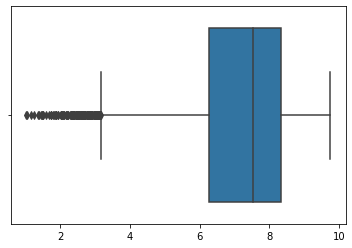

In [19]:
#Train the TF-IDF on Train data

tf_idf_vect = TfidfVectorizer(min_df = 10, max_features = 10000)
essay_tfidf_train = tf_idf_vect.fit_transform(X_tr['essay'].values)

#Calculating idf value
response = tf_idf_vect.fit_transform(X_tr['essay'].values)
idf_score = tf_idf_vect.idf_ # obtaining the idf score from TFIDFVECTORIZER
feature_names = tf_idf_vect.get_feature_names()
idfscore_feat=[]
for i in range(len(idf_score)):
  idfscore_feat.append([idf_score[i],feature_names[i]])
  idfscore_feat.sort()
sns.boxplot(idf_score)
#idfscore_feat=idfscore_feat[:3000]
#some top features in idfscore_feat list
for i in idfscore_feat[:10]:
  print(i)

In [0]:
#idfscore_feat=idfscore_feat[:3000]
#some top features in idfscore_feat list
for i in idfscore_feat[:10]:
  print(i)

[1.0075946642740503, 'students']
[1.0449310032339192, 'nannan']
[1.1629758650168092, 'school']
[1.2454920014603308, 'my']
[1.3630351163579622, 'learning']
[1.392964723259112, 'classroom']
[1.4462459844646436, 'not']
[1.4625116340243627, 'learn']
[1.468777247304226, 'the']
[1.5010148795350806, 'they']


In [0]:
sorted_idf = np.argsort(idf_score)[::-1]
sorted_idf
#feature_names = tf_idf_vect.get_feature_names()
imp_words = {feature_names[e] for  e in sorted_idf[2000:10000]}
not_imp_words = []
for word in feature_names:
  if word not in imp_words:
    not_imp_words.append(word)

In [0]:
def remove_words_with_lowidfValue(sentences):
  processed = []
  for sent in tqdm(sentences):
    sent = ' '.join(e for e in sent.split() if e not in not_imp_words)
    processed.append(sent)
  return processed

In [22]:
from tqdm import tqdm
essay_train = remove_words_with_lowidfValue(X_tr.essay)
essay_cv = remove_words_with_lowidfValue(X_cv.essay)
essay_test = remove_words_with_lowidfValue(X_test.essay)


100%|██████████| 21850/21850 [01:14<00:00, 293.59it/s]


In [0]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
def padded(encoded_docs):  
  max_length = 400
  padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
  return padded_docs

In [0]:
t = Tokenizer()
t.fit_on_texts(essay_train)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(essay_train)
essay_pad_train = padded(encoded_docs)

encoded_docs = t.texts_to_sequences(essay_cv)
essay_pad_cv = padded(encoded_docs)

encoded_docs = t.texts_to_sequences(essay_test)
essay_pad_test = padded(encoded_docs)



In [0]:
#Concatenating numerical features
rem_input_train = np.concatenate((X_tr['quantity'].values.reshape(-1,1),X_tr['price'].values.reshape(-1,1),X_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)
rem_input_cv = np.concatenate((X_cv['quantity'].values.reshape(-1,1),X_cv['price'].values.reshape(-1,1),X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)
rem_input_test = np.concatenate((X_test['quantity'].values.reshape(-1,1),X_test['price'].values.reshape(-1,1),X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)

In [25]:
#Embedding using Glove vectors
embeddings_index = dict()
f = open(r'/content/drive/My Drive/Applied ML assignments/glove.6B.300d.txt')
#with open('/content/drive/My Drive/Applied ML assignments/glove_vectors', 'rb') as f:
  #text = f.read()
for line in f:
  #line.decode(errors='ignore')
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [26]:
#create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

print("embedding matrix shape",embedding_matrix.shape)

embedding matrix shape (45460, 300)


In [0]:
y_binary_train = to_categorical(y_tr)
y_binary_cv = to_categorical(y_cv)
y_binary_test = to_categorical(y_test)

In [28]:
#Flattening the text input data after calculating embedding matrix using glove vectors
max_length = 400
ins = []
concat = []
text_input = Input(shape=(max_length,), name = "text_input")
# max_length = 150 ---->max length of sentence
ins.append(text_input)
e1 = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(text_input)

l1= LSTM(128,kernel_regularizer=l2(0.001),return_sequences=True)(e1)
#l1= LeakyReLU(alpha = 0.3)(l1)
f1= Flatten()(l1)
concat.append(f1)

In [0]:
#Combining Categorical features
#https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9
cat_vars = ["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"]

cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = X_tr[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)

In [0]:
for cat in cat_vars:
    x = Input((1,), name=cat)
    ins.append(x)
    x = Embedding(cat_sizes[cat]+1, cat_embsizes[cat], input_length=1)(x)
    x = Flatten()(x)
    concat.append(x)

In [0]:
rem_input_layer =  Input(shape=(3,), name="rem_input_layer")
ins.append(rem_input_layer)
rem_input_dense = Dense(64, activation='relu')(rem_input_layer)
concat.append(rem_input_dense)

In [32]:
#After concatenating text input, categorical and remaining numerical features, applying it to the model
from keras.layers import Concatenate
x = Concatenate()(concat)
#X=BatchNormalization()(X)
x= Dense(256,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(x)
#x= LeakyReLU(alpha = 0.3)(x)
x= Dropout(0.6)(x)
x= Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(x)
#x= LeakyReLU(alpha = 0.3)(x)
x= Dropout(0.5)(x)
x= Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(x)
#x= LeakyReLU(alpha = 0.3)(x)
x= Dropout(0.5)(x)
x= Dense(32,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(x)
#x= LeakyReLU(alpha = 0.3)(x)
x= Dropout(0.5)(x)
#x=BatchNormalization()(x)
x= Dense(16,activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2(0.002))(x)
#x= LeakyReLU(alpha = 0.3)(x)
#x= Dropout(0.25)(x)
output=Dense(2, activation='softmax')(x)
model_2 = Model(inputs=ins, outputs=output)
model_2.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     13638000    text_input[0][0]                 
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
school_state (InputLayer)       (None, 1)            0                    

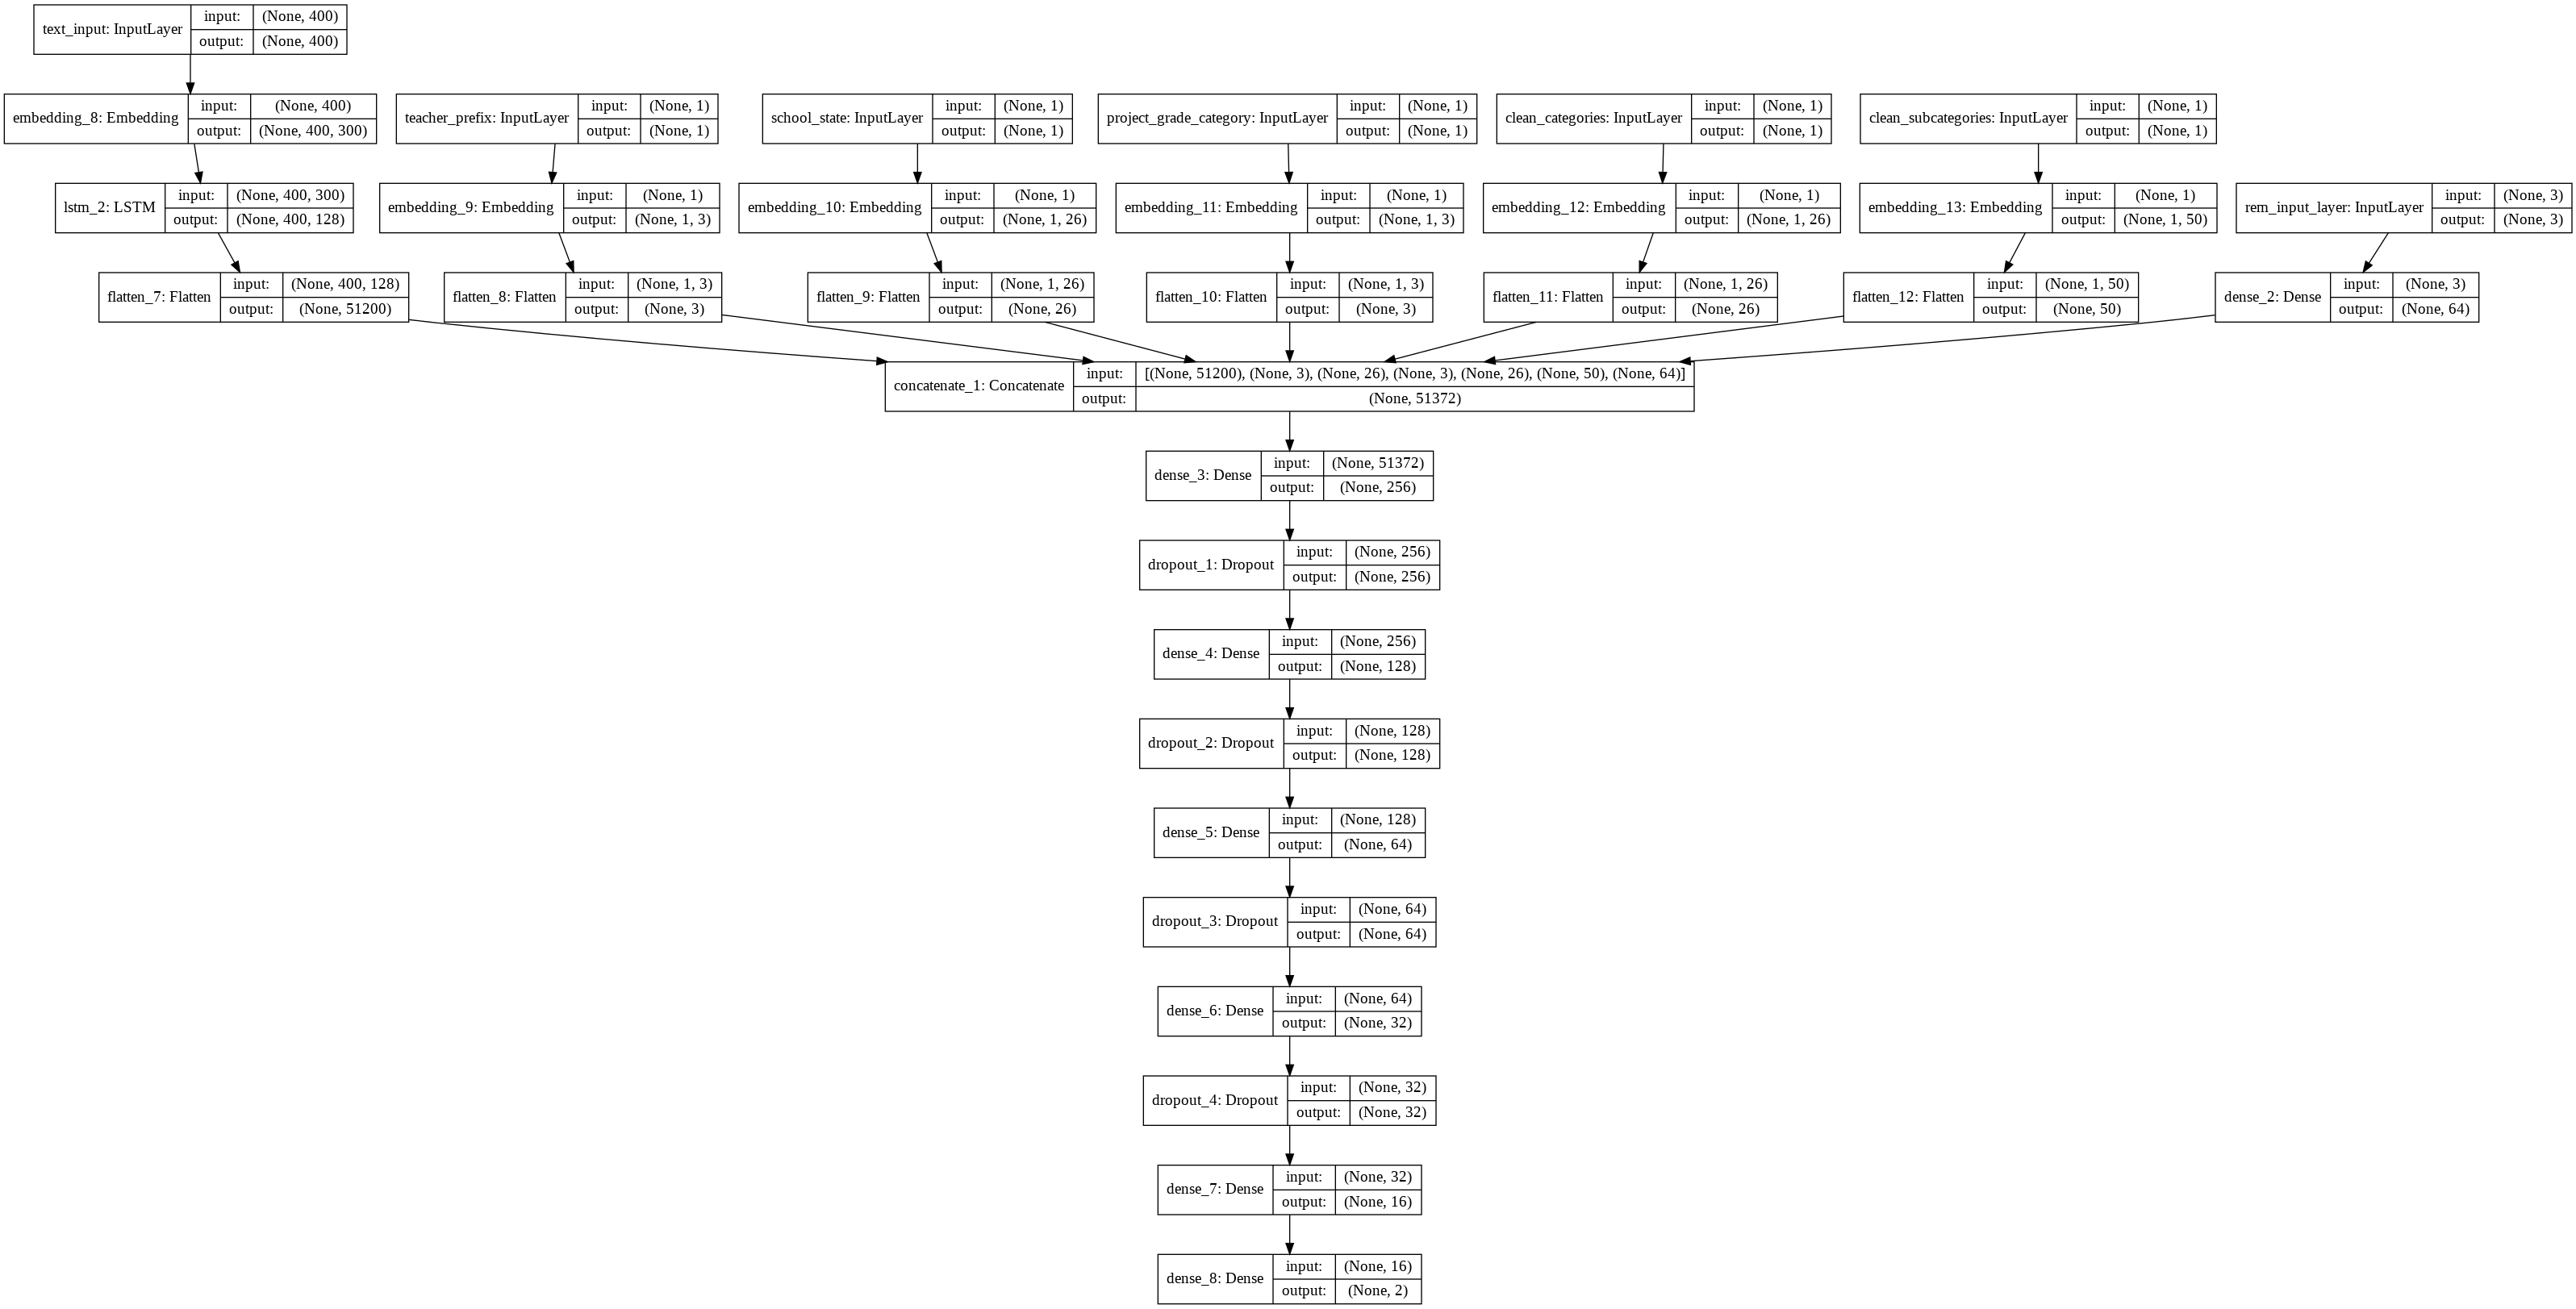

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model_2, to_file='/content/drive/My Drive/Applied ML assignments/model2.png', show_shapes=True, show_layer_names=True)

In [0]:
#https://stackoverflow.com/posts/51734992/revisions
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [35]:
adam = keras.optimizers.Adam(lr=0.001)
model_2.compile(optimizer=adam, loss='categorical_crossentropy',metrics=[auroc])
from keras.callbacks import *
tbc=TensorBoardColab()
earlystopping_2 = EarlyStopping(monitor='val_auc', patience=2, verbose=1,mode = 'max')
filepath = '/content/drive/My Drive/Applied ML assignments/epochs:{epoch:03d}-val_auc:{val_auroc:.3f}.hdf5'
#earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_auc', mode='max')
#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, verbose=1,min_lr=0.001, mode='min')
reduce_lr_2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.001,verbose = 1)
callbacks=[earlystopping_2, mcp_save, reduce_lr_2, TensorBoardColabCallback(tbc)]

#callbacks_list = [earlystopping_2]



Wait for 8 seconds...
TensorBoard link:
https://c07e4da9.ngrok.io


In [0]:
history_2= model_2.fit({'text_input': essay_pad_train, 'school_state': schoolstate_one_hot_train, 'project_grade_category': project_grade_category_one_hot_train,'clean_categories': categories_one_hot_train,'clean_subcategories':subcategories_one_hot_train, 'teacher_prefix':teacherprefix_ohe_train, 'rem_input_layer':rem_input_train},
          y_binary_train,epochs=15, batch_size=512,verbose=1, 
          validation_data=({'text_input': essay_pad_cv, 'school_state': schoolstate_one_hot_cv, 'project_grade_category': project_grade_category_one_hot_cv,'clean_categories': categories_one_hot_cv,'clean_subcategories':subcategories_one_hot_cv, 'teacher_prefix':teacherprefix_ohe_cv, 'rem_input_layer':rem_input_cv},
          y_binary_cv),callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples
Epoch 1/15
69918/69918 [==============================] - 1119s 16ms/step - loss: 2.3335 - auroc: 0.4858 - val_loss: 1.0010 - val_auroc: 0.5468
Epoch 2/15
69918/69918 [==============================] - 1113s 16ms/step - loss: 0.9594 - auroc: 0.5309 - val_loss: 0.8029 - val_auroc: 0.5970
Epoch 3/15
69918/69918 [==============================] - 1204s 17ms/step - loss: 0.8137 - auroc: 0.5522 - val_loss: 0.7469 - val_auroc: 0.6309
Epoch 4/15
69918/69918 [==============================] - 1123s 16ms/step - loss: 0.7304 - auroc: 0.5899 - val_loss: 0.6928 - val_auroc: 0.6491
Epoch 5/15
69918/69918 [==============================] - 1184s 17ms/step - loss: 0.6902 - auroc: 0.6220 - val_loss: 0.6654 - val_auroc: 0.6563
Epoch 6/15
69918/69918 [==============================] - 1133s 16ms/step - loss: 0.6596 - auroc: 0.6386 - val_loss: 0.6427 - val_auro

In [36]:
history_2= model_2.fit({'text_input': essay_pad_train, 'school_state': schoolstate_one_hot_train, 'project_grade_category': project_grade_category_one_hot_train,'clean_categories': categories_one_hot_train,'clean_subcategories':subcategories_one_hot_train, 'teacher_prefix':teacherprefix_ohe_train, 'rem_input_layer':rem_input_train},
          y_binary_train,epochs=20, batch_size=512,verbose=1, 
          validation_data=({'text_input': essay_pad_cv, 'school_state': schoolstate_one_hot_cv, 'project_grade_category': project_grade_category_one_hot_cv,'clean_categories': categories_one_hot_cv,'clean_subcategories':subcategories_one_hot_cv, 'teacher_prefix':teacherprefix_ohe_cv, 'rem_input_layer':rem_input_cv},
          y_binary_cv),callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 69918 samples, validate on 17480 samples


Epoch 1/20
69918/69918 [==============================] - 1061s 15ms/step - loss: 3.1376 - auroc: 0.4592 - val_loss: 1.3688 - val_auroc: 0.4353

Epoch 2/20
69918/69918 [==============================] - 1024s 15ms/step - loss: 1.3160 - auroc: 0.5301 - val_loss: 1.0144 - val_auroc: 0.6052
Epoch 3/20
69918/69918 [==============================] - 1041s 15ms/step - loss: 0.9094 - auroc: 0.6145 - val_loss: 0.8321 - val_auroc: 0.6882
Epoch 4/20
69918/69918 [==============================] - 1046s 15ms/step - loss: 0.8059 - auroc: 0.6691 - val_loss: 0.7676 - val_auroc: 0.7113
Epoch 5/20
69918/69918 [==============================] - 1021s 15ms/step - loss: 0.7501 - auroc: 0.6931 - val_loss: 0.7327 - val_auroc: 0.7123
Epoch 6/20
69918/69918 [==============================] - 1048s 15ms/step - loss: 0.7100 - auroc: 0.7131 - val_loss: 0.6971 - val_a

In [37]:
custom_objects = {"auroc":auroc}
#from keras.models import load_model
#best_model_2 = load_model('/content/drive/My Drive/Applied ML assignments/Epoch/epochs:011-val_acc:0.673.hdf5',custom_objects=custom_objects)
result = model_2.evaluate({'text_input': essay_pad_test, 'school_state': schoolstate_one_hot_test, 'project_grade_category': project_grade_category_one_hot_test,'clean_categories': categories_one_hot_test,'clean_subcategories':subcategories_one_hot_test, 'teacher_prefix':teacherprefix_ohe_test, 'rem_input_layer':rem_input_test},
          y_binary_test,batch_size=512)

21850/21850 [==============================] - 104s 5ms/step


In [38]:
print("{} of test data {}". format(model_2.metrics_names[0],result[0]))
print("{} of test data {}". format(model_2.metrics_names[1],result[1]))
#best_model_2.save("/content/drive/My Drive/Applied ML assignments/best_model_2.h5")

loss of test data 0.4492546766628117
auroc of test data 0.7514955499718008
